In [20]:
import pandas as pd
from scipy import stats
from utils import create_connection
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme()
#import geopandas as gpd
import matplotlib.pyplot as plt

# Load the Data Set for all NYC boroughs

In [2]:
# Connect to the database
database = "../data/apartments.db"
conn = create_connection(database)
c = conn.cursor()

In [3]:
# Query the database to extract all listings from NYC
nyc_counties = [
    "Manhattan County",
    "Bronx County",
    "Brooklyn",
    "Queens County",
    "Staten Island"
]

query = f"""SELECT * FROM units
            JOIN properties
            USING (property_name)
            WHERE city_name IN {str(tuple(nyc_counties))};
"""

units = pd.read_sql_query(query, conn)
conn.close()
units.rename(columns={'city_name':'borough'}, inplace=True)
units.head()


,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,latitude,longitude,neighborhood,zipcode,description,unique_features,borough,year_built,dishwasher,property_url
0,The Brooklyner,11201,1-06K,4060,1,1,684,2022-05-06,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,True,https://www.apartments.com/the-brooklyner-broo...
1,The Brooklyner,11201,1-09H,5122,2,2,976,2022-04-05,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,True,https://www.apartments.com/the-brooklyner-broo...
2,The Brooklyner,11201,1-10K,4349,1,1,618,2022-04-05,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,True,https://www.apartments.com/the-brooklyner-broo...
3,The Brooklyner,11201,1-11H,5195,2,2,976,2022-04-05,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,True,https://www.apartments.com/the-brooklyner-broo...
4,The Brooklyner,11201,1-16K,3997,1,1,618,2022-04-05,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,True,https://www.apartments.com/the-brooklyner-broo...


In [4]:
# Load MTA Stop locations and clean to useable form
# Data comes in the form of: POINT(LAT LONG)
mta_stops = pd.read_csv('../data/external/nyc/mta_locations.csv')['the_geom']
mta_stops.replace('[POINT()]', '',regex=True, inplace=True)
mta_stops = mta_stops.str.strip()
mta_stops = mta_stops.str.split(' ').to_list()

In [5]:
units.dtypes

property_name           object
property_zipcode        object
unit_id                 object
rent                    object
beds                    object
baths                   object
sqft                    object
date_available          object
date_scraped            object
fitness_center           int64
air_conditioning         int64
in_unit_washer_dryer     int64
laundry_facilities       int64
car_charging             int64
roof                     int64
concierge                int64
pool                     int64
elevator                 int64
garage                   int64
dogs_allowed             int64
cats_allowed             int64
income_restrictions      int64
latitude                object
longitude               object
neighborhood            object
zipcode                 object
description             object
unique_features         object
borough                 object
year_built              object
dishwasher              object
property_url            object
dtype: o

In [6]:
pd.concat([units.isnull().sum(),units.eq('').sum()],keys=['Nulls','Empty'],axis=1)

,Nulls,Empty
property_name,0,0
property_zipcode,0,0
unit_id,0,0
rent,0,9
beds,0,0
baths,0,0
sqft,0,1301
date_available,0,0
date_scraped,0,0
fitness_center,0,0


In [7]:
# Remove all units without square feet or rent values
# It's possible to impute these missing values
# but likely will skew any results that are generated
units = units[units.sqft != '']
units = units[units.rent != '']

In [8]:
units.rent=units.rent.astype(float)
units.sqft=units.sqft.astype(float)
units.beds=units.beds.astype(int)
units.baths=units.baths.astype(float)
units.latitude=units.latitude.astype(float)
units.longitude=units.longitude.astype(float)

# Initial exploration

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

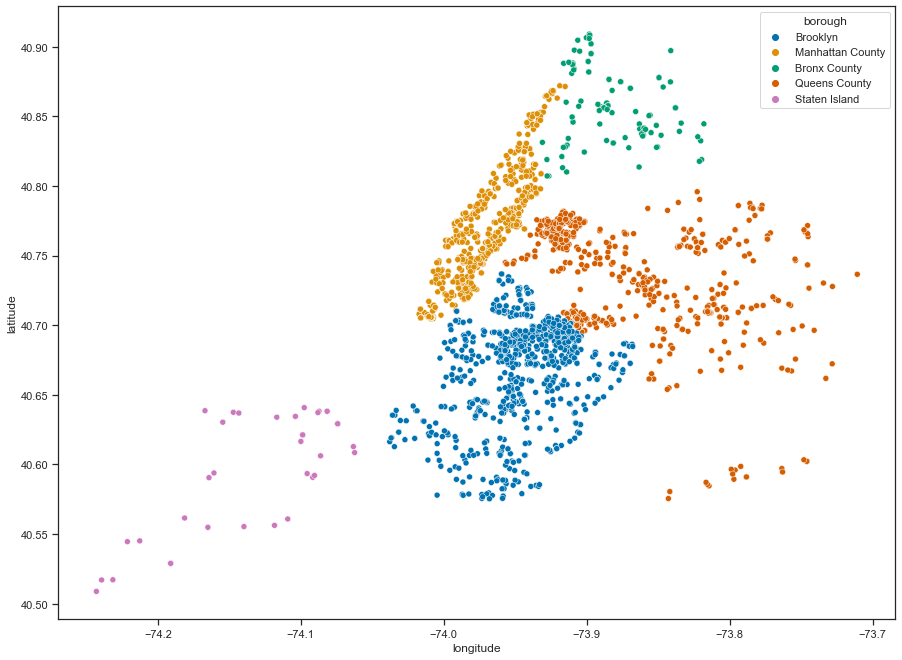

In [9]:
# Plotting the location of all the apartments
sns.set_style("ticks")
fig = plt.gcf()
scaler = abs((units.latitude.max()-units.latitude.min())/(units.longitude.max()-units.longitude.min()))
fig.set_size_inches(15, 15*scaler)

sns.scatterplot(data=units, x='longitude', y='latitude', hue = 'borough',palette='colorblind')

### Checking the data for outliers and bad data

In [10]:
# Descriptive stats based on setting a specific target column
def descriptive_stats(target,df):
    average = df.groupby('beds', as_index=True)[target].mean()
    ci_5 = df.groupby('beds', as_index=True)[target].quantile(0.05)    #5th Percentile
    ci_95 = df.groupby('beds', as_index=True)[target].quantile(0.95)   #95th Percentile
    minimum= df.groupby('beds', as_index=True)[target].min()
    maximum = df.groupby('beds', as_index=True)[target].max()
    std = df.groupby('beds', as_index=True)[target].std()
    num = df.groupby('beds', as_index=True)[target].count()
    
    stats_df = pd.DataFrame({f'Average {target}':average, 
                            '5th Percentile':ci_5,
                            '95th Percentile':ci_95,
                            'Minimum':minimum, 
                            'Maximum':maximum,
                            'Standard Deviation':std,
                            'Number of Units': num})
    
    stats_df.reset_index(inplace=True)
    return stats_df

In [11]:
# Get the descriptive stats for the rent column
descriptive_stats('rent',units)

,beds,Average rent,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,2806.490172,1354.80,4531.50,1050.0,8000.0,1136.218474,407
1,1,3158.505508,1600.00,5502.20,700.0,8000.0,1336.547398,817
2,2,3594.904571,1995.00,7618.60,1500.0,12000.0,1906.269508,875
3,3,3821.359968,2270.35,7451.55,925.0,23250.0,2229.905505,632
4,4,4450.558140,2549.70,7823.50,1300.0,20775.0,2359.380757,215
5,5,5017.027778,3100.00,8462.50,2850.0,11000.0,2045.532700,36
6,6,5146.000000,1890.00,7942.00,1350.0,7970.0,2162.659878,9


In [12]:
# Get the descriptive stats for the sqft column
descriptive_stats('sqft',units)

,beds,Average sqft,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,507.953317,101.3,921.00,1.0,7200.0,404.655615,407
1,1,741.169523,500.0,1000.00,1.0,10000.0,398.800724,817
2,2,943.567429,603.5,1350.00,1.0,3600.0,306.502464,875
3,3,1130.002373,800.0,1909.45,1.0,3800.0,374.790755,632
4,4,1325.576744,835.0,2039.30,1.0,9999.0,971.536918,215
5,5,2098.472222,1200.0,6368.25,1200.0,9999.0,2095.378609,36
6,6,1636.222222,580.0,3105.60,400.0,3976.0,1007.848423,9


In [13]:
# Drop the 5 and 6 bedroom units since they make up a small portion of the dataset
units = units[units.beds < 5]

In [14]:
units[units.sqft < 51]

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,latitude,longitude,neighborhood,zipcode,description,unique_features,borough,year_built,dishwasher,property_url
464,238 Fort Washington Ave,10032,41,2995.0,3,1.0,3.0,2022-04-04,2022-04-04,0,...,40.84307,-73.94155,Washington Heights,10032,NO BROKER FEE!!True 3bed steps to COLUMBIA Med...,,Manhattan County,NULL,False,https://www.apartments.com/238-fort-washington...
472,175 West 87th Street,10024,175-17A,5900.0,2,2.0,1.0,2022-04-05,2022-04-05,1,...,40.78850,-73.97387,Upper West Side,10024,Elegance meets cosmopolitan flair at 175 West ...,"Bike Storage, Courtyard, Pet Friendly",Manhattan County,1975,True,https://www.apartments.com/175-west-87th-stree...
481,529 Broome St,10013,3,4244.0,2,1.0,1.0,2022-04-05,2022-04-05,0,...,40.72388,-74.00423,SoHo,10013,Great deal in Soho!large 2 bedrooms in great ...,,Manhattan County,NULL,False,https://www.apartments.com/529-broome-st-new-y...
543,121 Madison Ave,10016,19,6495.0,4,2.0,1.0,2022-04-04,2022-04-04,0,...,40.74525,-73.98450,Kips Bay,10016,This spacious convertible 4 bedroom apartment ...,,Manhattan County,NULL,True,https://www.apartments.com/121-madison-ave-new...
544,240 W 15th St,10011,3,2600.0,1,1.0,1.0,2022-04-05,2022-04-05,0,...,40.73980,-74.00110,Chelsea,10011,Sunny 1 bedroom on quiet street with dishwashe...,,Manhattan County,NULL,True,https://www.apartments.com/240-w-15th-st-new-y...
605,159 W 72nd St,10023,10,3850.0,1,1.0,1.0,2022-04-04,2022-04-04,0,...,40.77851,-73.98064,Upper West Side,10023,Newly renovated huge 1 bed in prime Upper West...,,Manhattan County,NULL,False,https://www.apartments.com/159-w-72nd-st-new-y...
708,656 W 171st St,10032,5D,2395.0,2,1.0,5.0,2022-04-04,2022-04-04,0,...,40.84360,-73.94064,Washington Heights,10032,Beautifully Renovated KING 1 BEDSteps to Colu...,,Manhattan County,NULL,False,https://www.apartments.com/656-w-171st-st-new-...
709,656 W 171st St,10032,5F,1995.0,1,1.0,5.0,2022-04-04,2022-04-04,0,...,40.84360,-73.94064,Washington Heights,10032,Beautifully Renovated KING 1 BEDSteps to Colu...,,Manhattan County,NULL,False,https://www.apartments.com/656-w-171st-st-new-...
1296,618 W 142nd St,10031,1C,2195.0,1,1.0,1.0,2022-04-04,2022-04-04,0,...,40.82482,-73.95318,Hamilton Heights,10031,large 1 brEntrance Foyertons of Closet spaceSe...,,Manhattan County,NULL,False,https://www.apartments.com/618-w-142nd-st-new-...
1299,725 W 172nd St,10032,67,1895.0,1,1.0,6.0,2022-04-04,2022-04-04,0,...,40.84539,-73.94186,Washington Heights,10032,NO FEEBright and Sunny two bedroomSteps to COL...,,Manhattan County,NULL,False,https://www.apartments.com/725-w-172nd-st-new-...


None of these units appear to be listings that can represent realistic expectations. As noted before, it is possible to impute these values but we will proceed for now with removing them. There are many factors that can drive the size of the unit beyond comparing to what it should be given the rent and number of bedrooms. 

In [15]:
# Drop all units less than 50sqft
units = units[units.sqft > 51]

In [16]:
units[units.sqft > 4000]

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,latitude,longitude,neighborhood,zipcode,description,unique_features,borough,year_built,dishwasher,property_url
665,22 Park Ave,10016,005C,5195.0,1,1.0,10000.0,2022-04-05,2022-04-05,1,...,40.74798,-73.98088,Murray Hill,10016,This building combines the charisma of old New...,,Manhattan County,NULL,False,https://www.apartments.com/22-park-ave-new-yor...
1226,895 Park Ave,10075,895 Park Ave,8000.0,0,1.0,7200.0,2022-04-05,2022-04-05,1,...,40.77529,-73.96035,Upper East Side,10075,"Upper East Side, 1.0 Bathroom, 7.0 Rooms, Heal...",,Manhattan County,NULL,False,https://www.apartments.com/895-park-ave-new-yo...
2834,445 Deisius St,10312,1st Floor and Basement,3500.0,4,3.0,4700.0,2022-04-05,2022-04-05,0,...,40.52894,-74.19103,Prince's Bay,10312,Brand new construction with stainless steel ap...,,Staten Island,NULL,True,https://www.apartments.com/445-deisius-st-stat...
2894,84 Newel St,11222,2L,2957.0,4,1.0,9999.0,2022-04-05,2022-04-05,0,...,40.72539,-73.94743,Brooklyn,11222,"NO FEE! Affordable, true 4BR on a quiet block ...",,Brooklyn,NULL,False,https://www.apartments.com/84-newel-st-brookly...
3867,551 Graham Ave,11222,3L,3800.0,4,2.0,9999.0,2022-04-05,2022-04-05,0,...,40.72193,-73.94732,Greenpoint,11222,"NO FEE! True 4BR/2BA on Graham Ave, 2 blocks f...",,Brooklyn,NULL,False,https://www.apartments.com/551-graham-ave-broo...


In [17]:
# Drop all units with more than 5,000 square feet
units = units[units.sqft < 5000]

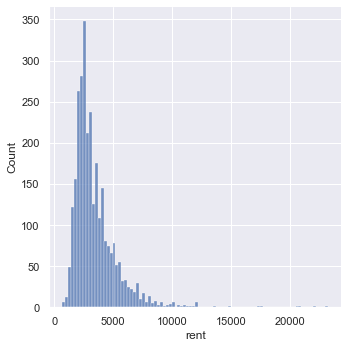

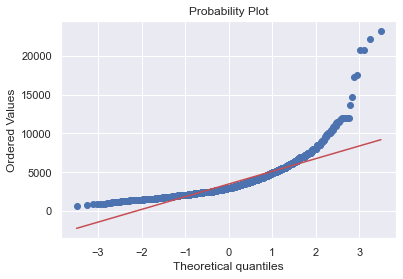

In [21]:
#Distribution of the rent column
sns.displot(units.rent)
fig = plt.figure()
res = stats.probplot(units.rent, plot=plt)

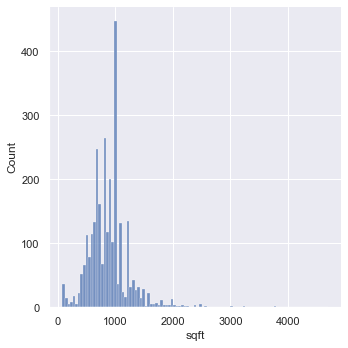

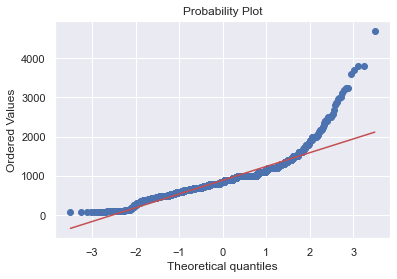

In [22]:
#Distribution of the sqft column
sns.displot(units.sqft)
fig = plt.figure()
res = stats.probplot(units.sqft, plot=plt)

In [29]:
# Detecting possible outliers with standard deviation and IQR 
def outlier_detection(target,df_input):
    
    # Adjust the distributions since they are not normal
    if target == 'rent':
        df_input.loc[:, 'rent'] = np.log(df_input.rent)
    elif target == 'sqft':
        df_input.loc[:, 'sqft'] = np.log(df_input.sqft)
    
    # Boundary zones
    average = df_input.groupby('beds', as_index=True)[target].mean()
    std = df_input.groupby('beds', as_index=True)[target].std()
    upper_limit = average + 3*std
    lower_limit = average - 3*std
    
    # Quartile Range
    iqr_25 = df_input.groupby('beds', as_index=True)[target].quantile(0.25)    
    iqr_75 = df_input.groupby('beds', as_index=True)[target].quantile(0.75)   
    iqr = iqr_75 - iqr_25
    iqr_upper = iqr_75 + iqr
    iqr_lower = iqr_25 - iqr
    
    # Set the conditions for upper limit
    cond1 = df_input[target] > df_input.beds.map(upper_limit)
    cond2 = df_input[target] > df_input.beds.map(iqr_upper)
    
    # Set the conditions for lower limit
    cond3 = df_input[target] < df_input.beds.map(lower_limit)
    cond4 = df_input[target] < df_input.beds.map(iqr_lower)

    outlier_df = df_input[(cond1 | cond2)]
    
    # Take the exponential to revert back to the original data condition
    if target == 'rent':
        outlier_df.loc[:,target] = np.exp(outlier_df.loc[:,target])
    elif target == 'sqft':
        outlier_df.loc[:,target] = np.exp(outlier_df.loc[:,target])
        
    # Filter out any income restriction units
    outlier_df = outlier_df[outlier_df.income_restrictions != 1]
    
    #stats_df.reset_index(inplace=True)
    return outlier_df

In [30]:
outliers = pd.concat([outlier_detection('rent', units.copy()),outlier_detection('sqft', units.copy())]).drop_duplicates()
outliers.head(10)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,latitude,longitude,neighborhood,zipcode,description,unique_features,borough,year_built,dishwasher,property_url
53,322 W 57th St Unit 42B,10019,42B,12000.0,2,2.0,1350.0,2022-04-05,2022-04-05,1,...,40.76706,-73.98408,Hell's Kitchen,10019,This contemporary high end furnished two bedro...,,Manhattan County,NULL,False,https://www.apartments.com/322-w-57th-st-new-y...
108,51 Murray St,10007,3,6950.0,3,2.0,1300.0,2022-04-04,2022-04-04,0,...,40.71430,-74.00941,Tribeca,10007,Buildings luxury loft rentals feature high cei...,,Manhattan County,NULL,True,https://www.apartments.com/51-murray-st-new-yo...
116,National at 888 6th Ave Furnished Apartments,10001,Studio,7500.0,0,1.0,475.0,2022-04-05,2022-04-05,1,...,40.74817,-73.98867,Chelsea,10001,"Spacious fully furnished apartments, located i...","24 Hour Doorman, Complimentary Washer/dryer Ev...",Manhattan County,NULL,True,https://www.apartments.com/national-at-888-6th...
130,155 W 75th St,10023,BFR,7890.0,3,2.5,2000.0,2022-04-04,2022-04-04,0,...,40.78042,-73.97940,Upper West Side,10023,Check out this awesome newly renovated three ...,,Manhattan County,NULL,False,https://www.apartments.com/155-w-75th-st-new-y...
196,120 E 10th St,10003,1,8450.0,4,2.0,1600.0,2022-08-01,2022-04-04,0,...,40.73020,-73.98817,East Village,10003,120 E 10th St is an apartment located inManhat...,,Manhattan County,NULL,False,https://www.apartments.com/120-e-10th-st-new-y...
198,120 E 10th St,10003,4,8450.0,4,2.0,900.0,2022-07-01,2022-04-04,0,...,40.73020,-73.98817,East Village,10003,120 E 10th St is an apartment located inManhat...,,Manhattan County,NULL,False,https://www.apartments.com/120-e-10th-st-new-y...
213,600 W 57th St,10019,3,7995.0,4,2.0,1400.0,2022-04-04,2022-04-04,0,...,40.77029,-73.99184,Hell's Kitchen,10019,• Pricing is subject to change daily. Terms an...,,Manhattan County,NULL,True,https://www.apartments.com/600-w-57th-st-new-y...
220,The Continental,10001,2 Bedroom,7995.0,2,2.0,1175.0,2022-04-05,2022-04-05,1,...,40.74846,-73.98925,Chelsea,10001,Find your new home at The Continental. This pr...,,Manhattan County,2011,True,https://www.apartments.com/the-continental-new...
231,Anagram Nomad,10016,2 Bedroom / 2 Bathroom,8514.0,2,2.0,1050.0,2022-04-21,2022-04-05,1,...,40.74475,-73.98619,NoMad,10016,Now offering flexible touring options includin...,"24-Hour-Attended Lobby, Balcon, Balcony, Bicyc...",Manhattan County,1998,True,https://www.apartments.com/anagram-nomad-new-y...
232,Anagram Nomad,10016,3 Bedroom / 3 Bathroom,14748.0,3,3.0,1618.0,2022-06-04,2022-04-05,1,...,40.74475,-73.98619,NoMad,10016,Now offering flexible touring options includin...,"24-Hour-Attended Lobby, Balcon, Balcony, Bicyc...",Manhattan County,1998,True,https://www.apartments.com/anagram-nomad-new-y...


In [ ]:
# Drop all the extreme outliers as they represent less than 1% of the data (3+ standard deviations away)
